# Digital Elevation Model (DEM) Tile Preprocessing

This Jupyter Notebook is dedicated to the initial, essential preprocessing steps required for the 1 arc-second resolution Digital Elevation Model (DEM) tiles covering the Ohio Region study area - 104 in total. Given the computational intensity associated with processing numerous high-resolution raster tiles, a strategy leveraging Virtual Raster Tiles (VRTs) will be employed instead of physically merging the tiles into a single large raster dataset. This approach allows for efficient handling of the data volume by treating the collection of tiles as a single virtual dataset without creating a massive intermediate file.

The preprocessing workflow in this notebook focuses on preparing the DEM data for subsequent watershed delineation, a process that is inherently agnostic to projection at this stage. Therefore, reprojection to a specific projected coordinate system like UTM will not be performed on the raw or preprocessed tiles. Instead, projection will be applied later to the delineated watershed boundaries and derived vector features.

The specific steps undertaken in this notebook are:

1.  **Verification of Coordinate Reference System (CRS) and Resolution:** Ensuring that all individual 1 arc-second DEM tiles are consistently referenced to the NAD83 datum (EPSG:4269), which is the native CRS for this dataset and, that all individual DEM tiles have same resolution (expected 1 arc-second, aproximately 0.000277778 degrees and aproximately 30 meters).
2.  **Filling Pits and Depressions:** Applying algorithms to identify and fill sinks and depressions within each individual DEM tile. Sinks (or pits) are local topographic lows surrounded by higher elevation values, where water flow would terminate in a standard flow direction calculation. Filling these depressions creates a hydrologically connected surface by raising the elevation of sink cells to the level of their lowest spill point. This step is critical for accurately determining continuous flow paths across the terrain, which is a necessary prerequisite for deriving flow direction and accumulation grids used in automated watershed delineation.
3.  **Creation of Virtual Raster Tiles (VRTs):** Constructing VRT files that virtually mosaic raw and the preprocessed (sink-filled) individual DEM tiles. These VRTs will serve as the input for subsequent terrain analysis steps, allowing seamless access to the data across tile boundaries without the need for physical mosaicking.

The output of this notebook will be a collection of sink-filled DEM tiles, organized into VRT, ready for flow direction and accumulation calculations leading to watershed delineation.

In [54]:
# Import libraries
import rasterio
import glob
from pysheds.grid import Grid
# import numpy as np
from tqdm.notebook import tqdm
from subprocess import run
from pathlib import Path
import os
from matplotlib import pyplot as plt

In [2]:
# Set paths
project_root_path = Path.cwd().parent.parent
dem_dir = project_root_path / 'data' / 'bronze' / 'geo' / 'raster' / 'dem1arcsec'
filled_dir = project_root_path /'data' / 'silver' / 'geo' / 'raster' / 'dem1arcsec_filled'
filled_dir.mkdir(parents=True, exist_ok=True)

## Step 1: Verify NAD83 CRS and Resolution

Check the CRS of each DEM tile to ensure it’s NAD83 (expected: EPSG:4269). Report any tiles with a different CRS for manual inspection.

In [ ]:
# Verify Coordinate Reference System (CRS)
# Get list of DEM files
dem_files = list(dem_dir.glob('*.tif'))
print(f"Found {len(dem_files)} DEM files.")

# Expected NAD83 CRS codes
nad83_crs = 'EPSG:4269'

# Check CRS for each tile
mismatched_tiles = []
for dem_file in tqdm(dem_files, desc="Checking CRS"):
    with rasterio.open(dem_file) as src:
        crs = str(src.crs).upper()
        if crs != nad83_crs:
            mismatched_tiles.append((dem_file, crs))

# Report results
if mismatched_tiles:
    print("\nTiles with non-NAD83 CRS:")
    for tile, crs in mismatched_tiles:
        print(f"{tile}: {crs}")
    print("Tiles should be reprojected to NAD83 (EPSG:4269).")
else:
    print("\nAll tiles are in NAD83 (EPSG:4269).")

Found 104 DEM files.


Checking CRS:   0%|          | 0/104 [00:00<?, ?it/s]


All tiles are in NAD83 (EPSG:4269).


In [ ]:
# Verify Resolution
# Get list of DEM files
dem_files = list(dem_dir.glob('*.tif'))
print(f"Found {len(dem_files)} DEM files.")

# Expected NAD83 CRS codes
expected_res = [0.000277778,-0.000277778]

# Check CRS for each tile
mismatched_res_tiles = []
for dem_file in tqdm(dem_files, desc="Checking CRS"):
    with rasterio.open(dem_file) as src:
        x_res = round(src.meta['transform'][0], 9)
        y_res = round(src.meta['transform'][4], 9)
        if x_res not in  expected_res or y_res not in expected_res:
            mismatched_res_tiles.append((dem_file, (x_res, y_res)))

# Report results
if mismatched_res_tiles:
    print(f'Found {len(mismatched_res_tiles)} tiles with non-1-arc sec resolution.')
    print("\nTiles with non-1-arc sec resolution:")
    for tile, res in mismatched_res_tiles:
        print(f"{tile}: {res}")
    print("Tiles should be reprojected to 1-arc sec resolution.")
else:
    print("\nAll tiles are in 1-arc sec resolution.")

Found 104 DEM files.


Checking CRS:   0%|          | 0/104 [00:00<?, ?it/s]


All tiles are in 1-arc sec resolution.


## Step 2: Fill Sinks (Pits and Depressions)

Create a Virtual Raster Tile (VRT) to reference all 104 DEM tiles as a single dataset, avoiding memory-intensive merging for filling depression and sinks. Filling process will be performed, for each tile, considering its neighbouring cell, through the use of VRT. This ensures a hydrologically conditioned DEM for watershed delineation. Outputs are saved with LZW compression to reduce disk usage.

**LZW (Lempel-Ziv-Welch)** compression is a lossless data compression algorithm used to reduce the file size of raster data, such as GeoTIFF files (your DEM tiles), without losing any information. It is widely supported in geospatial tools like GDAL, rasterio, and GIS software (e.g., QGIS), making it ideal for compressing DEMs while preserving their exact elevation values.

- **Lossless:** Unlike lossy compression (e.g., JPEG), LZW ensures that the decompressed data is identical to the original, which is critical for scientific applications, where elevation accuracy affects flow paths and derived characteristics (e.g., slope, area).

- **Purpose**: LZW compression reduces the disk space required for the filled DEM tiles and minimizes I/O bottlenecks when reading/writing files.

### Create VRT

In [49]:
# Create VRT for original DEMs
dem_files = glob.glob(str(dem_dir / '*.tif'))
raw_vrt = project_root_path / 'data' / 'bronze' / 'geo' / 'raster' / 'dem1arcsec.vrt'
# Create VRT using gdalbuildvrt
print("Creating VRT for original DEMs...")
try:
    result = run(
        ['gdalbuildvrt', str(raw_vrt)] + dem_files,
        capture_output=True, text=True, check=True
    )
    print(f"VRT created: {raw_vrt}")
except FileNotFoundError:
    print("Error: gdalbuildvrt not found. Ensure GDAL is installed and in PATH.")
    print("Install with: brew install gdal")
except run.CalledProcessError as e:
    print(f"Error: VRT creation failed. gdalbuildvrt returned code {e.returncode}")
    print(f"STDERR: {e.stderr}")
    print(f"STDOUT: {e.stdout}")
except Exception as e:
    print(f"Unexpected error: {str(e)}")

# Verify VRT exists
if raw_vrt.exists():
    print(f"Confirmed: VRT file exists at {raw_vrt}")
else:
    print("Error: VRT file was not created.")

Creating VRT for original DEMs...
VRT created: /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/bronze/geo/raster/dem1arcsec.vrt
Confirmed: VRT file exists at /Users/alan/Data Science Projects/ML-ModClark-IUH-Model/data/bronze/geo/raster/dem1arcsec.vrt


### Fill Sinks

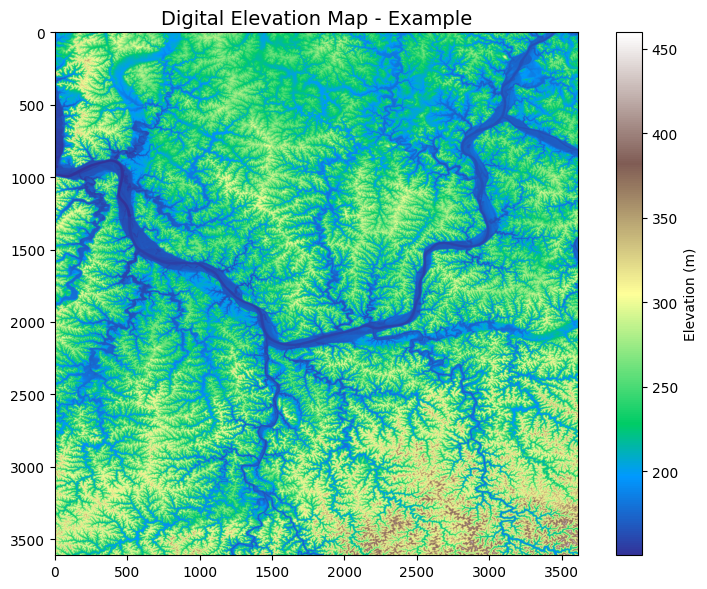

In [ ]:

# set paths
filled_dir = project_root_path / 'data' / 'silver' / 'geo' / 'raster' / 'dem1arcsec_filled'
original_vrt = raw_vrt
filled_dir.mkdir(parents=True, exist_ok=True)

# Get DEM file
dem_file = glob.glob(f"{dem_dir}/*.tif")[2]

grid = Grid.from_raster(dem_file)
dem = grid.read_raster(dem_file)

# Plot the raw DEM
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.view(dem), cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Digital Elevation Map - Example', size=14)
plt.tight_layout()


In [72]:
# Create fresh DEM with explicit specifications
new_dem = grid.new_raster(
    np.array(dem, dtype=np.float32),
    viewfinder=dem.viewfinder.copy(),
    nodata=np.float32(-9999.0),
    mask=dem.mask.copy() if hasattr(dem, 'mask') else None
)

pits = grid.detect_pits(new_dem)

AttributeError: 'sGrid' object has no attribute 'new_raster'

In [70]:

# Detect pits
pits = grid.detect_pits(dem, nodata=-9999.0)

# Plot pits
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(pits, cmap='Greys_r', zorder=1)
plt.title('Pits', size=14)
plt.tight_layout()

TypeError: `nodata` value not representable in dtype of array.

In [ ]:
print(f"Processing DEM tile: {os.path.basename(dem_file)}")
# Open VRT
with rasterio.open(original_vrt) as vrt_src:
    vrt_profile = vrt_src.profile
    vrt_transform = vrt_src.transform

# Buffer size (pixels) to include neighboring tile data
buffer_pixels = 10

# Process the single tile's extent
with rasterio.open(dem_file) as tile_src:
    tile_bounds = tile_src.bounds
    tile_profile = tile_src.profile

    # Convert tile bounds to VRT pixel coordinates
    col_start, row_start = ~vrt_transform * (tile_bounds.left, tile_bounds.top)
    col_stop, row_stop = ~vrt_transform * (tile_bounds.right, tile_bounds.bottom)
    col_start, row_start = int(col_start), int(row_start)
    col_stop, row_stop = int(col_stop), int(row_stop)

    # Add buffer, ensuring it stays within VRT bounds
    window = rasterio.windows.Window(
        col_off=max(0, col_start - buffer_pixels),
        row_off=max(0, row_start - buffer_pixels),
        width=min(vrt_src.width - col_start + buffer_pixels, col_stop - col_start + 2 * buffer_pixels),
        height=min(vrt_src.height - row_start + buffer_pixels, row_stop - row_start + 2 * buffer_pixels)
    )

    # Read buffered window from VRT
    data = vrt_src.read(1, window=window)

# Initialize pysheds grid with VRT metadata
grid = Grid.from_raster(original_vrt)

# Fill depressions
filled_dem = grid.condition_flood(data)

# Crop back to original tile extent (remove buffer)
buffer_start = buffer_pixels if window.col_off < col_start else 0
buffer_top = buffer_pixels if window.row_off < row_start else 0
cropped_data = filled_dem[buffer_top:buffer_top + (row_stop - row_start),
                         buffer_start:buffer_start + (col_stop - col_start)]

# Save filled tile with LZW compression
output_file = os.path.join(filled_dir, os.path.basename(dem_file))
with rasterio.open(
    output_file, 'w', driver='GTiff', height=cropped_data.shape[0],
    width=cropped_data.shape[1], count=1, dtype=cropped_data.dtype,
    crs=tile_profile['crs'], transform=tile_profile['transform'],
    compress='LZW', nodata=vrt_profile.get('nodata', -9999)
) as dst:
    dst.write(cropped_data, 1)

print(f"Filled DEM saved to: {output_file}")

In [ ]:
# Set paths
filled_dir = project_root_path / 'data' / 'silver' / 'geo' / 'raster' / 'dem1arcsec_filled'
original_vrt = raw_vrt
filled_dir.mkdir(parents=True, exist_ok=True)

# Get list of DEM tiles
dem_files = glob.glob(f"{dem_dir}/*.tif")
print(f"Found {len(dem_files)} DEM tiles.")

# Open VRT
with rasterio.open(original_vrt) as vrt_src:
    vrt_profile = vrt_src.profile
    vrt_transform = vrt_src.transform

# Buffer size (pixels) to include neighboring tile data
buffer_pixels = 10

# Process each tile's extent
for dem_file in tqdm(dem_files, desc="Filling depressions"):
    # Get tile's window in VRT coordinates
    with rasterio.open(dem_file) as tile_src:
        tile_bounds = tile_src.bounds
        tile_profile = tile_src.profile

        # Convert tile bounds to VRT pixel coordinates
        col_start, row_start = ~vrt_transform * (tile_bounds.left, tile_bounds.top)
        col_stop, row_stop = ~vrt_transform * (tile_bounds.right, tile_bounds.bottom)
        col_start, row_start = int(col_start), int(row_start)
        col_stop, row_stop = int(col_stop), int(row_stop)

        # Add buffer, ensuring it stays within VRT bounds
        window = rasterio.windows.Window(
            col_off=max(0, col_start - buffer_pixels),
            row_off=max(0, row_start - buffer_pixels),
            width=min(vrt_src.width - col_start + buffer_pixels, col_stop - col_start + 2 * buffer_pixels),
            height=min(vrt_src.height - row_start + buffer_pixels, row_stop - row_start + 2 * buffer_pixels)
        )

        # Read buffered window from VRT
        data = vrt_src.read(1, window=window)

    # Initialize pysheds grid with VRT metadata
    grid = Grid.from_raster(original_vrt)

    # Fill depressions
    filled_dem = grid.condition_flood(data)

    # Crop back to original tile extent (remove buffer)
    buffer_start = buffer_pixels if window.col_off < col_start else 0
    buffer_top = buffer_pixels if window.row_off < row_start else 0
    cropped_data = filled_dem[buffer_top:buffer_top + (row_stop - row_start),
                             buffer_start:buffer_start + (col_stop - col_start)]

    # Save filled tile with LZW compression
    output_file = os.path.join(filled_dir, os.path.basename(dem_file))
    with rasterio.open(
        output_file, 'w', driver='GTiff', height=cropped_data.shape[0],
        width=cropped_data.shape[1], count=1, dtype=cropped_data.dtype,
        crs=tile_profile['crs'], transform=tile_profile['transform'],
        compress='LZW', nodata=vrt_profile.get('nodata', -9999)
    ) as dst:
        dst.write(cropped_data, 1)

print(f"Filled DEMs saved to: {filled_dir}")

## Step 4: Verify Filled DEMs

Check a sample filled DEM to ensure no depressions remain.

In [ ]:
# Verify one filled DEM
filled_files = glob.glob(f"{filled_dir}/*.tif")
if filled_files:
    sample_file = filled_files[0]
    dem = rd.LoadGDAL(sample_file)
    depressions = rd.IdentifyDepressions(dem)
    if not depressions.any():
        print(f"Verification passed: No depressions in {sample_file}")
    else:
        print(f"Warning: Depressions remain in {sample_file}")
else:
    print("Error: No filled DEMs found.")

## Step 5: Create VRT for Filled DEMs

Create a VRT for the filled DEMs, which will be used for watershed delineation in the next notebook.

In [ ]:
# Create VRT for filled DEMs
print("Creating VRT for filled DEMs...")
call(['gdalbuildvrt', filled_vrt, f"{filled_dir}/*.tif"])
if os.path.exists(filled_vrt):
    print(f"VRT created: {filled_vrt}")
    print("Ready for watershed delineation in the next notebook.")
else:
    print("Error: VRT creation failed.")

## Notes
- **Memory Usage**: Tile-by-tile processing keeps memory usage low, suitable for 8 GB RAM.
- **Disk Space**: Ensure 15 GB free for input (5.57 GB) and output files (~5–7 GB).
- **Next Steps**: Use `ohio_dem_filled.vrt` in the next notebook for flow direction and watershed delineation.
- **Troubleshooting**: If memory errors occur, reduce `richdem`’s memory footprint by processing smaller tiles or using TauDEM (`PitRemove`).

Save this notebook and proceed to the watershed delineation notebook.